In [23]:
import numpy as np
import matplotlib.pyplot as plt
from utils.opt_utils import *
import h5py
import pickle
from qutip import *
import time
import tqdm

In [24]:
wc_A = 4.069814 * (10**9) * 2 * np.pi  # cavity A frequency
wc_B = 6.096062 * (10**9) * 2 * np.pi  # cavity A frequency
wa =  5.325 * (10**9) * 2 * np.pi  # atom frequency
dt_A = np.abs(wc_A - wa) / (2 * np.pi)
dt_B = np.abs(wc_B - wa) / (2 * np.pi)
chi_A = 0.00215 * (10**9) * 2 * np.pi
chi_B = 0.00544 * (10**9) * 2 * np.pi
g_A = np.sqrt(chi_A * dt_A) * 2 * np.pi  # coupling strength w/ cavity A
g_B = np.sqrt(chi_B * dt_B) * 2 * np.pi  # coupling strength w/ cavity B

gamma = 333333.333        # atom dissipation rate
kappa_A = 10000       # cavity A dissipation rate
kappa_B = 10000       # cavity B dissipation rate

temp_q = 0.01        # avg number of thermal bath excitation for qubit
temp_A = 0.04        # avg number of thermal bath excitation for cavity A
temp_B = 0.05        # avg number of thermal bath excitation for cavity B

In [25]:
cavity_dims = 6

def cost_q_e(final_expect, final_state):
    return  np.power(np.abs(final_state[cavity_dims]), 2)

def cost_qA_g1(final_expect, final_state):
    return np.power(np.abs(final_state[1][0]), 2)

In [26]:
max_segs = 20
us = 0.000001
time_start = 0.0000000
time_stop = 2 * us
init_amp = 4000000
n_steps = 501


num_drives = 2
num_elems = 2
num_cavities = 1
# cavity_dims = 8
state_sizes = [2, cavity_dims]
state_vals = [0, 0]
sim_options = Options()
element_freqs = [wa, wc_B]
output_cost_func = cost_qA_g1
verbose = True


t_arr = np.linspace(time_start, time_stop, n_steps)

t_step = (time_stop - time_start) / n_steps

sim_options.store_final_state = True

sm, a_B, a_A, sx, sz = reg_ops(num_cavities + 1, cavity_dims)
drive_freqs = np.array(element_freqs)

gammas = [gamma, kappa_B]
temps = [temp_q, temp_B]
c_ops = [] # gen_c_ops(elements, [sm, a_A, a_B, sx, sz], gammas, temps)

# Operators used in Hamiltonian
drive_ops = [sm.dag(), sm, a_B.dag(), a_B]
element_ops = [sz, a_B.dag() * a_B]
H_0 = (chi_B * a_B.dag() * a_B * sz / 2)
eval_ops = [sm.dag() * sm, a_B.dag() * a_B]

init_state = tensor((basis(state_sizes[0], 0) * np.sqrt(1 - state_vals[0])) + (basis(state_sizes[0], 1) * np.sqrt(state_vals[0])), (basis(state_sizes[1], 0) * np.sqrt(1 - state_vals[1])) + (basis(state_sizes[1], 1) * np.sqrt(state_vals[1])))

client_args = [num_drives, drive_ops, element_freqs, H_0, init_state, t_arr, eval_ops, sim_options, output_cost_func, verbose, time_start, time_stop]

In [27]:
freqs = np.array(element_freqs)

N_segs = 10
amp_times = np.linspace(time_start, time_stop, N_segs + 1)

times = np.array([amp_times, amp_times, amp_times, amp_times])

In [ ]:
A_i = 0
A_f = 20000000
N_amp = 51

verbose = False

client_args = [num_drives, drive_ops, element_freqs, H_0, init_state, t_arr, eval_ops, sim_options, output_cost_func, verbose, time_start, time_stop]

q_pi_sigma = 0.25 * us
A1_pi_sigma = 0.05 * us
A2_pi_sigma = 0.05 * us
B1_pi_sigma = 0.05 * us
B2_pi_sigma = 0.05 * us

A_arr = np.linspace(A_i, A_f, N_amp)

costs = []

for A in tqdm.tqdm(A_arr):
    amp_funcs = [[zero], [zero],
                 [gauss_gen(A, (time_start + time_stop) / 8, B1_pi_sigma, 1)], [zero]]
    amp_func = [func_sum(amp_funcs[i]) for i in range(len(amp_funcs))]
    
    amp_pts = np.array([amp_func[i](amp_times) for i in range(len(amp_func))])
    # print(amp_pts)
    
    # for i in range(len(amp_func)):
    #     plt.plot(amp_times, amp_pts[i], label=f'A: {A}, drive: {i}')
    
    client_opts = np.append(np.append(amp_pts[:, 1:-1].flatten(), times[:, 1:-1].flatten()), freqs)
    
    res = sim_interp_cost_eval(client_opts, *client_args)
    costs.append(res[0])
    # print(f'Amp: {A}, cost: {res[0][0]}')
plt.show()

  4%|▍         | 2/51 [00:33<15:45, 19.30s/it]

In [12]:
print(costs)

[0.0, 0.0]


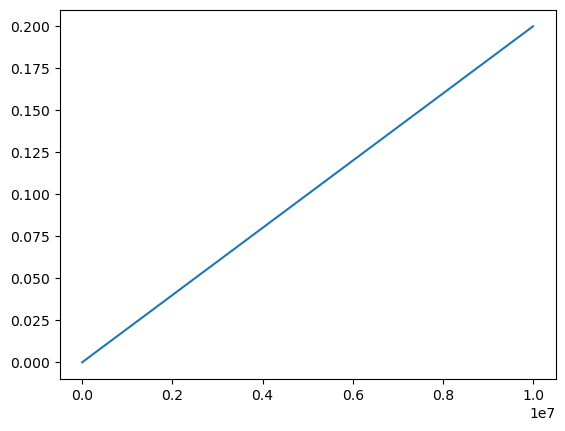

In [31]:
plt.plot(A_arr, costs)
plt.show()